In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pvpf.constants import OUTPUT_ROOT
from typing import List, Optional
from pvpf.utils.date_range import date_range
import numpy as np
from pvpf.property.training_property import RFTrainingProperty
from pvpf.trainer.rf_trainer import _center_crop_tf
from pvpf.tfrecord.high_level import load_dataset
import tensorflow as tf
from pvpf.token.training_token import TRAINING_TOKENS
from pvpf.utils.indicator import compute_error_rate
from pvpf.utils.dataset_to_numpy import dataset_to_numpy

### Functions and Constants

In [2]:
def entire_dataframe(trial_name: str) -> pd.DataFrame:
    path = OUTPUT_ROOT.joinpath(trial_name, "output.csv")
    df = pd.read_csv(path, index_col=False)
    unnamed_column_name = "Unnamed: 0"
    if unnamed_column_name in df.columns:
        df = df.drop(unnamed_column_name, axis=1)
    df["datetime"] = pd.to_datetime(df.loc[:, "datetime"])
    return df

def range_dataframe(df: pd.DataFrame, start: datetime, end: datetime) -> pd.DataFrame:
    cond = (start <= df["datetime"]) & (df["datetime"] < end)
    return df.loc[cond, :]

In [3]:
train_prop = TRAINING_TOKENS["rf_preaugumented"]
prop = RFTrainingProperty(train_prop, image_size=(1, 1))
def center_feature(feature_names: List[str]) -> np.ndarray:
    feature_indices = {feature_name: prop.training_property.tfrecord_property.feature_names.index(feature_name) \
        for feature_name in feature_names}
    train_feature, test_feature, _train_target, _test_target = load_dataset(
        prop.training_property
    )
    datasets: List[tf.data.Dataset] = [train_feature, test_feature]
    datasets = [dataset.map(
        lambda tensor: _center_crop_tf(tensor, prop.image_size)
    ) for dataset in datasets]

    def extract(datasets: tf.data.Dataset, feature_idx: int):
        datasets = [dataset.map(lambda tensor: tensor[feature_idx]) for dataset in datasets]
        ans = np.concatenate([dataset_to_numpy(dataset) for dataset in datasets], axis=0)
        return ans

    return {feature_name: extract(datasets, feature_idx) for feature_name, feature_idx in feature_indices.items()}

In [4]:
def plot(df: pd.DataFrame, column_names: Optional[List[str]] = None, x_name: str = "datetime"):
    if column_names is None:
        column_names = df.columns
    df = df.loc[:, column_names]
    _figure, ax = plt.subplots(figsize=(15, 10))

    x = df.loc[:, x_name]
    for column_name in column_names:
        if column_name != x_name:
            ax.plot(x, df.loc[:, column_name], label=column_name)
    ax.legend()


### Parameters

In [5]:
rf_trial_name = "rf_2021:11:19-14:04:47"
dl_trial_name = "dl_2021:11:01-00:00:00"
feature_names = ["tcdc", "dswrf"]
rf_df = entire_dataframe(rf_trial_name)
dl_df = entire_dataframe(dl_trial_name)

feature_dic = center_feature(feature_names)
comparison_dict = {
    "datetime": rf_df.loc[:, "datetime"],
    "target": rf_df.loc[:, "target"],
    "random forest": rf_df.loc[:, "prediction"],
    "deep learning": dl_df.loc[:, "prediction"],
}
comparison_dict.update(feature_dic)
comparison_df = pd.DataFrame(comparison_dict)

2021-11-30 09:19:30.088177: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-30 09:19:31.813996: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9660 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:19:00.0, compute capability: 7.5
2021-11-30 09:19:31.814989: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9660 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2021-11-30 09:19:31.815891: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/repli

### Display

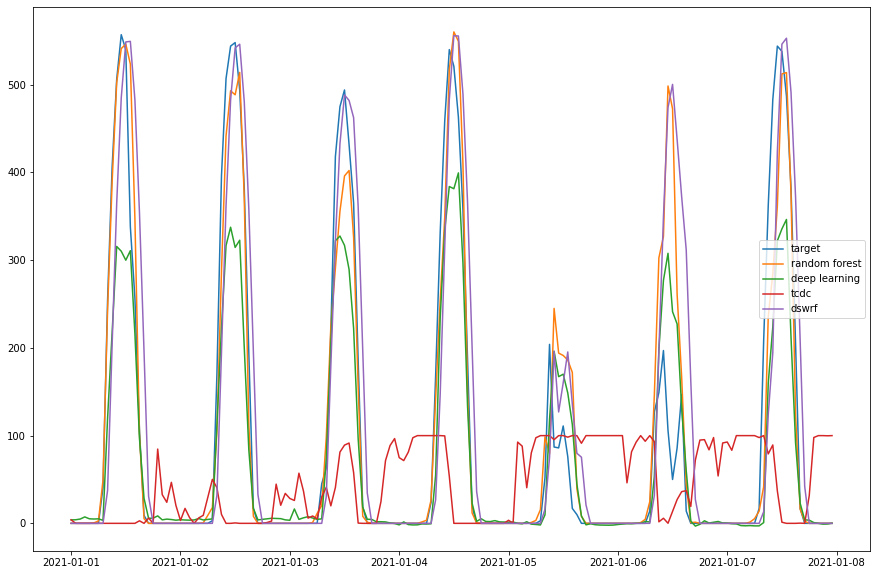

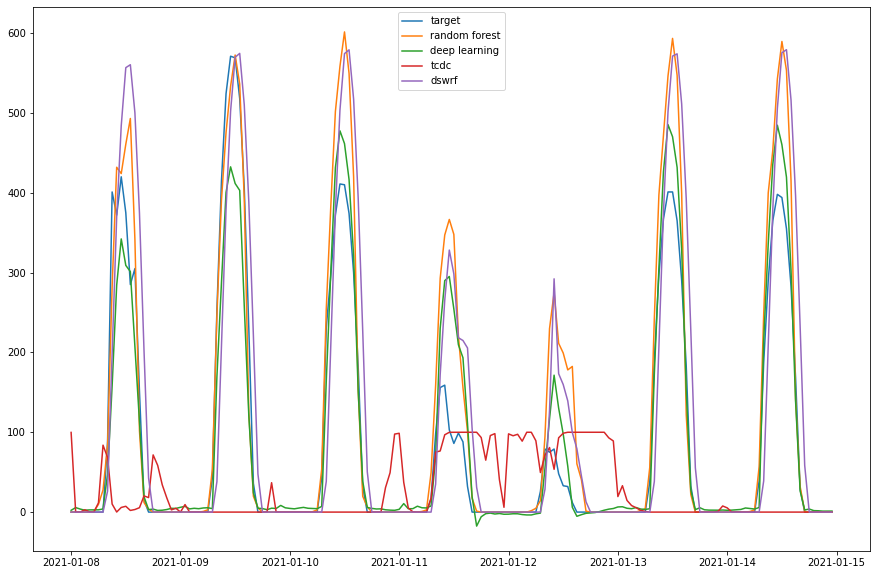

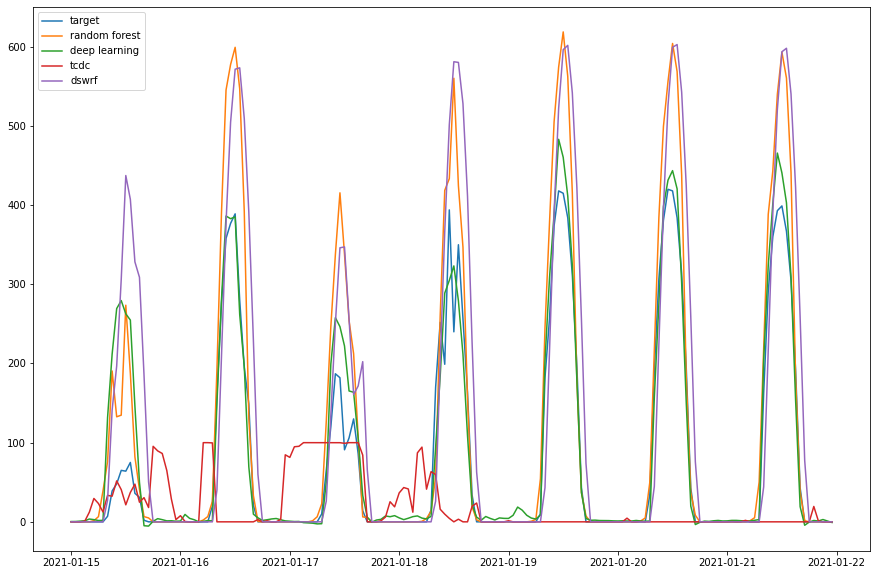

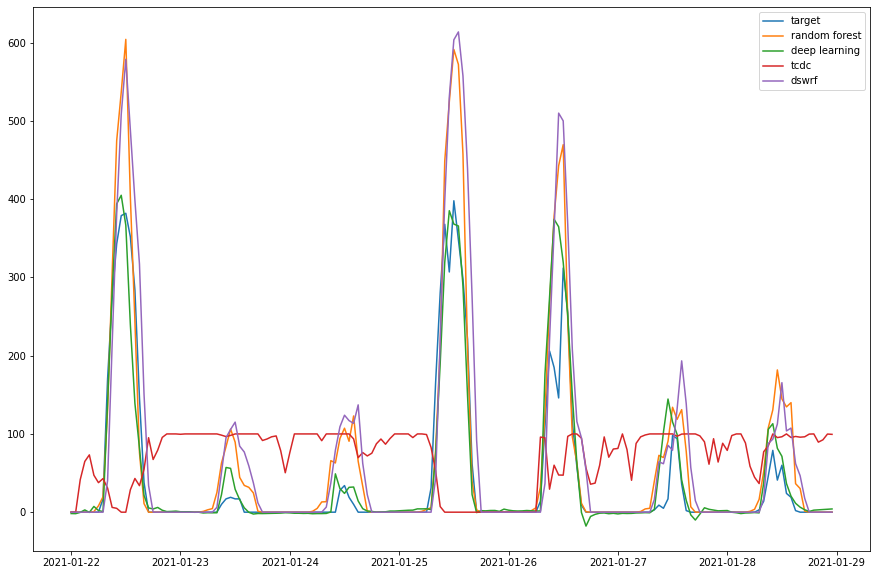

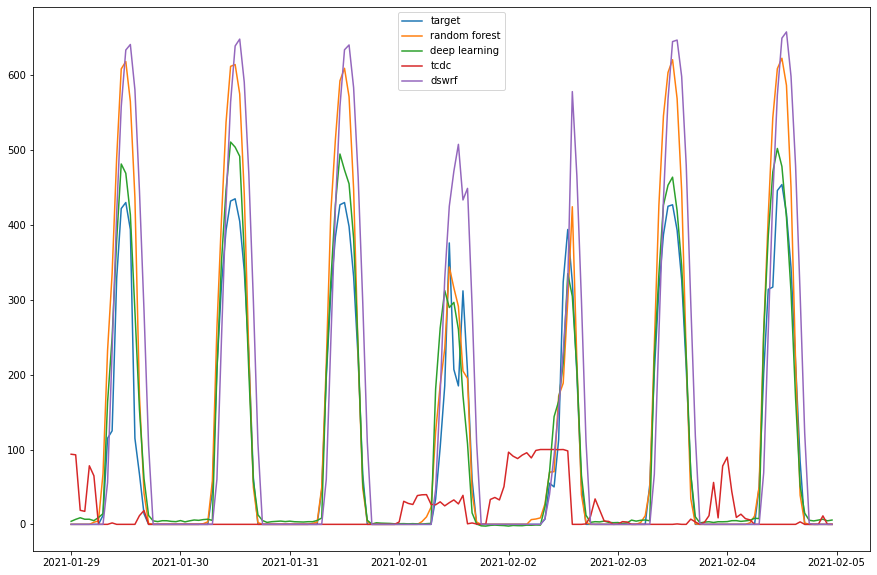

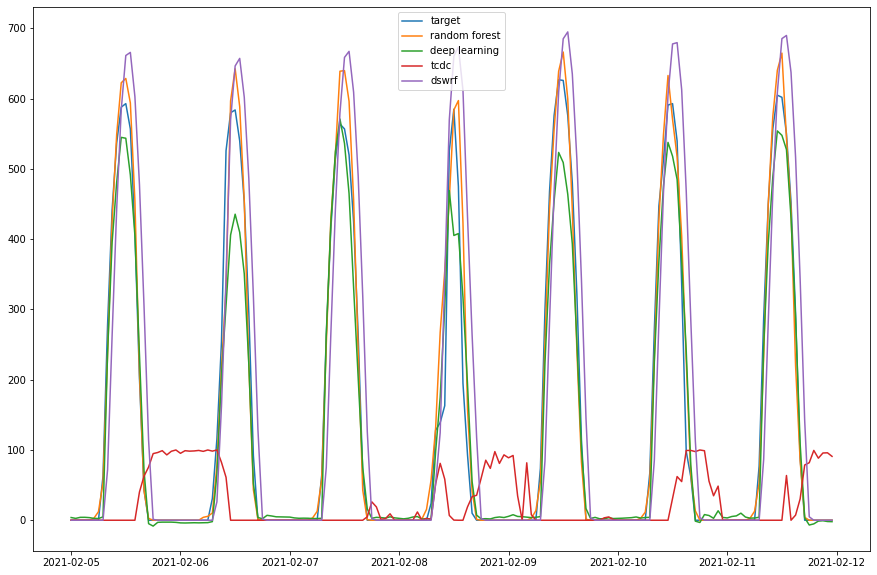

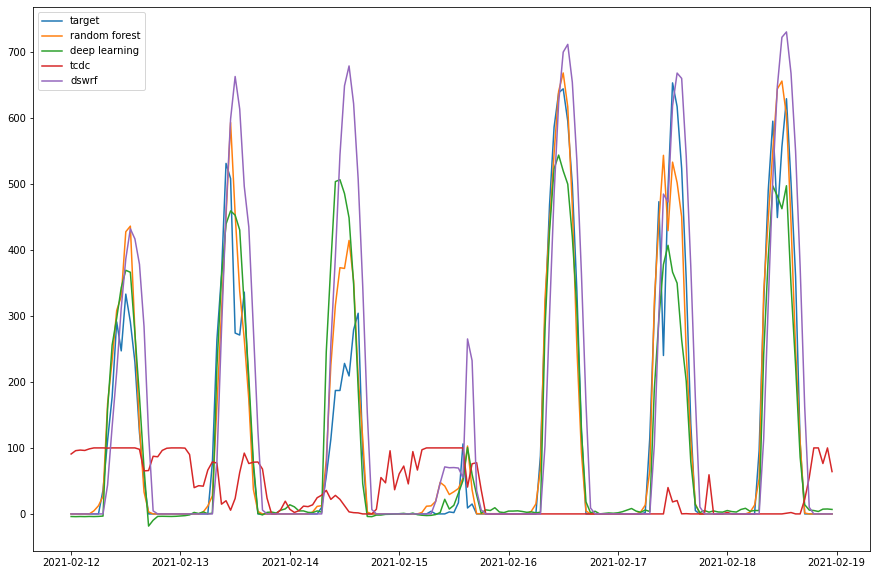

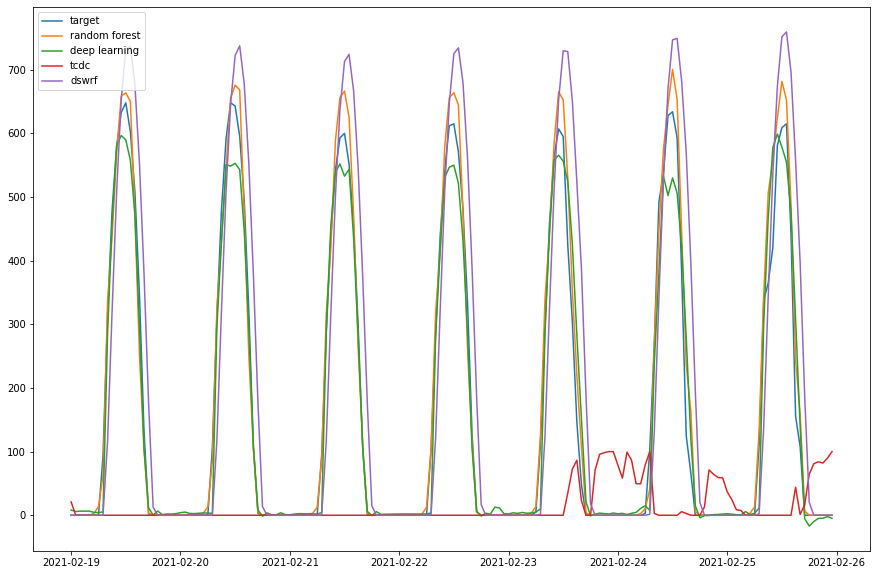

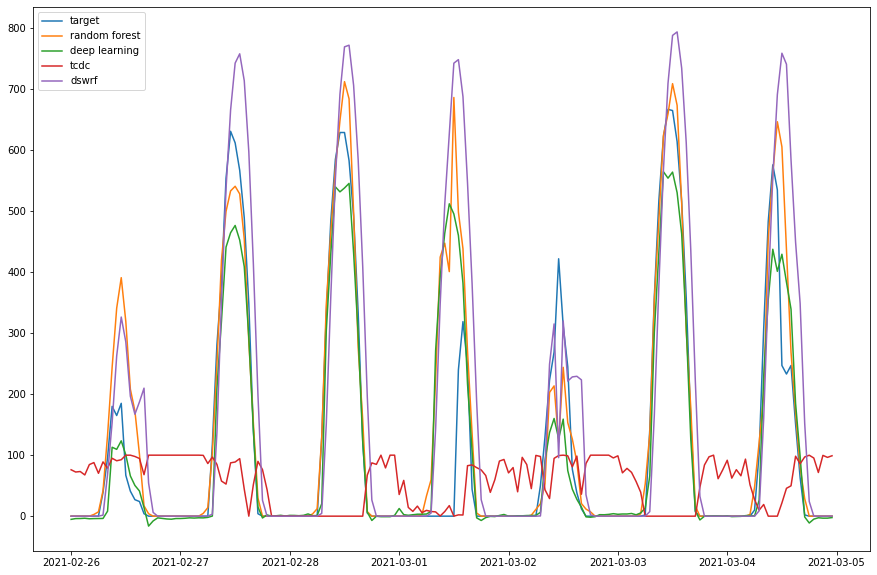

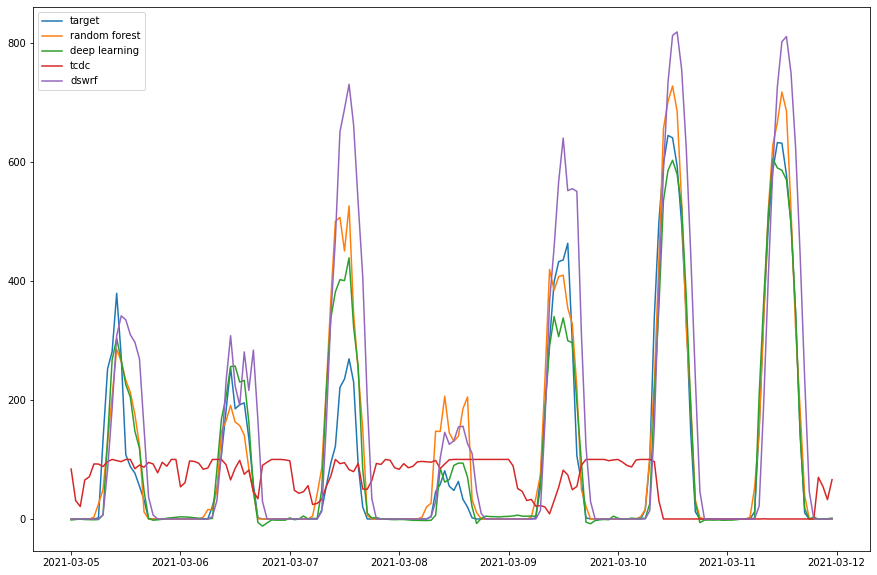

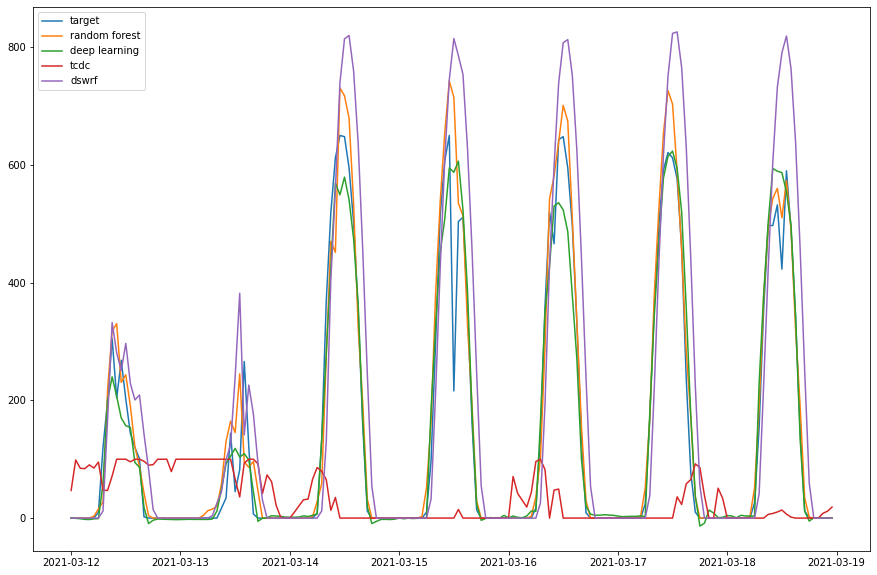

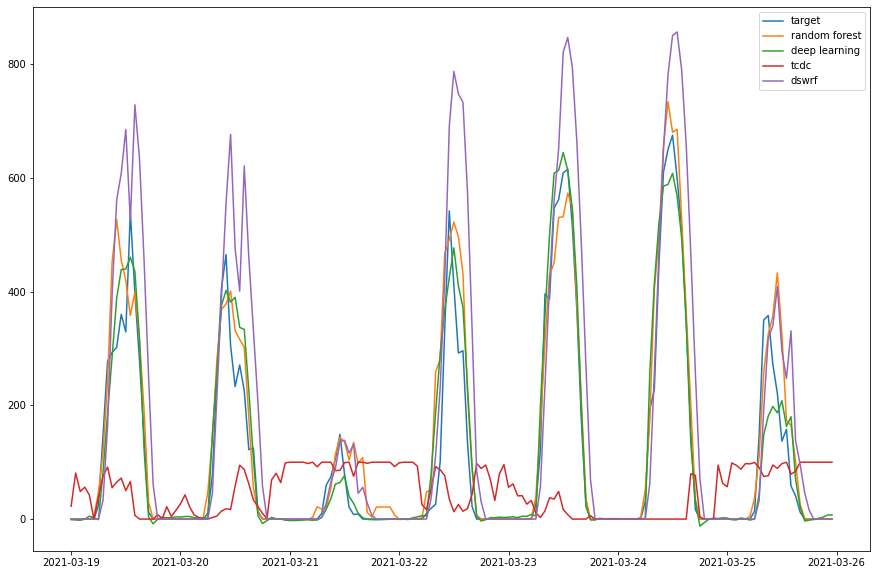

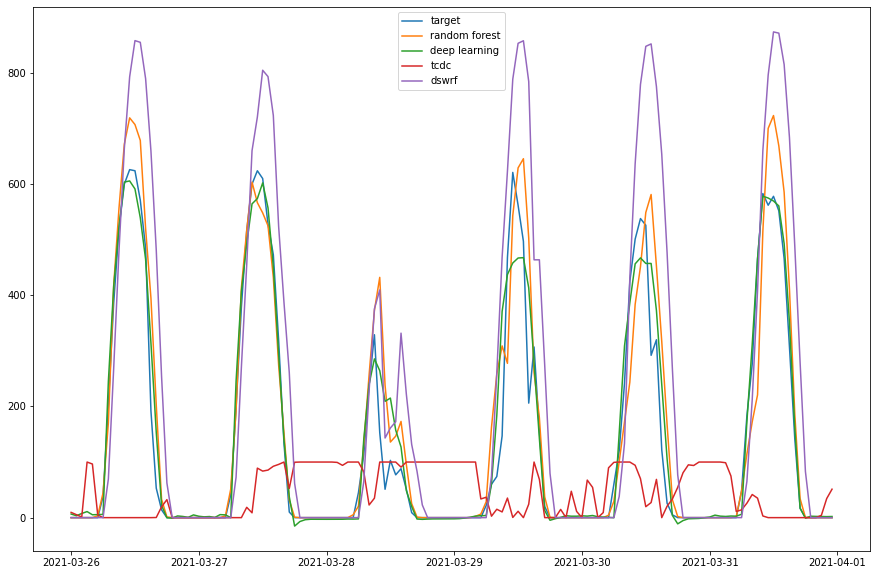

In [6]:
week = timedelta(days=7)
for start in date_range(datetime(2021, 1, 1, 0, 0, 0), datetime(2021, 4, 1, 0, 0, 0), week):
    end = min(datetime(2021, 7, 1, 0, 0, 0), start + week)
    weekly_df = range_dataframe(comparison_df, start, end)
    plot(weekly_df)

### 雲面積による検討
テスト期間の日中 (8:00 ~ 16:00)を抽出

In [7]:
rf_trial_name = "rf_2021:11:19-14:04:47"
dl_trial_name = "dl_2021:11:01-00:00:00"
feature_names = ["tcdc"]
rf_df = entire_dataframe(rf_trial_name)
dl_df = entire_dataframe(dl_trial_name)

feature_dic = center_feature(feature_names)
comparison_dict = {
    "datetime": rf_df.loc[:, "datetime"],
    "target": rf_df.loc[:, "target"],
    "random forest": rf_df.loc[:, "prediction"],
    "deep learning": dl_df.loc[:, "prediction"],
}
comparison_dict.update(feature_dic)
comparison_df = pd.DataFrame(comparison_dict)
comparison_df = range_dataframe(comparison_df, datetime(2021, 1, 1, 0, 0, 0), datetime(2021, 4, 1, 0, 0, 0))
hours = pd.DatetimeIndex(comparison_df.loc[:, "datetime"]).hour
hour_cond = (8 <= hours) & (hours <= 18)
comparison_df = comparison_df.loc[hour_cond, :]

In [8]:
med_tcdc = np.median(comparison_df.loc[:, "tcdc"].values)
sunny = comparison_df.loc[:, "tcdc"] < med_tcdc
sunny_dl = comparison_df.loc[sunny, "deep learning"]
cloudy_dl = comparison_df.loc[~sunny, "deep learning"]
sunny_rf = comparison_df.loc[sunny, "random forest"]
cloudy_rf = comparison_df.loc[~sunny, "random forest"]
sunny_target = comparison_df.loc[sunny, "target"]
cloudy_target = comparison_df.loc[~sunny, "target"]
print(f"median_tcdc: {med_tcdc}")

median_tcdc: 6.201174736022949


In [9]:
sunny_dl_error_rate = compute_error_rate(sunny_dl, sunny_target)
cloudy_dl_error_rate = compute_error_rate(cloudy_dl, cloudy_target)
sunny_rf_error_rate = compute_error_rate(sunny_rf, sunny_target)
cloudy_rf_error_rate = compute_error_rate(cloudy_rf, cloudy_target)
print(f"DL Sunny Error: {sunny_dl_error_rate}")
print(f"DL Cloudy Error: {cloudy_dl_error_rate}")
print(f"RF Sunny Error: {sunny_rf_error_rate}")
print(f"RF Cloudy Error: {cloudy_rf_error_rate}")

DL Sunny Error: 0.1601355775695221
DL Cloudy Error: 0.3911157181343446
RF Sunny Error: 0.19809383785181114
RF Cloudy Error: 0.44391510097586556


In [10]:
total_dl = comparison_df.loc[:, "deep learning"]
total_rf = comparison_df.loc[:, "random forest"]
total_target = comparison_df.loc[:, "target"]
total_dl_error = compute_error_rate(total_dl, total_target)
total_rf_error = compute_error_rate(total_rf, total_target)
print(f"DL Total Error: {total_dl_error}")
print(f"RF Total Error: {total_rf_error}")

DL Total Error: 0.23767073633658478
RF Total Error: 0.2806108482668018


In [ ]:
plt.plot()